# Tutorial 7: Slide-seqV2 mouse olfactory bulb (pyG framework)

This tutorial demonstrates how to identify spatial domains on Slide-seqV2 data using STAGATE based on pyG (PyTorch Geometric) framework.

Benefit from the optimization of the pyG package for training graph neural networks, it is more than 10x faster than STAGATE based on the tensorflow1 framework, and can use a batch training strategy to deal with large-scale data (See Tutorial 8).

The download and installation of the STAGATE package based on the pyG framework can be found at https://github.com/zhanglabtools/STAGATE_pyG.

In this tutorial, we foucs on the Slide-seqV2 mouse olfactory bulb data (Puck_200127_15 from https://singlecell.broadinstitute.org/single_cell/study/SCP815/highly-sensitive-spatial-transcriptomics-at-near-cellular-resolution-with-slide-seqv2#study-summary).

We removed spots outside the main tissue area, and the used spots can be downloaded from https://drive.google.com/drive/folders/10lhz5VY7YfvHrtV40MwaqLmWz56U9eBP?usp=sharing.

## Preparation

In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import os
import sys

In [2]:
import torch
import STAGATE_pyG

In [3]:
input_dir = 'Data'
counts_file = os.path.join(input_dir, 'Puck_200127_15.digital_expression.txt')
coor_file = os.path.join(input_dir, 'Puck_200127_15_bead_locations.csv')

In [4]:
counts = pd.read_csv(counts_file, sep='\t', index_col=0)
coor_df = pd.read_csv(coor_file, index_col=0)
print(counts.shape, coor_df.shape)

(21220, 21724) (21724, 2)


In [5]:
adata = sc.AnnData(counts.T)
adata.var_names_make_unique()
coor_df = coor_df.loc[adata.obs_names, ['xcoord', 'ycoord']]
adata.obsm["spatial"] = coor_df.to_numpy()

In [6]:
sc.pp.calculate_qc_metrics(adata, inplace=True)

In [7]:
adata

AnnData object with n_obs × n_vars = 21724 × 21220
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    obsm: 'spatial'

(-289.81710000000004, 6312.7151, 173.30850000000004, 5709.8615)

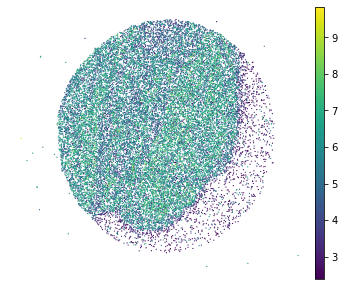

In [8]:
plt.rcParams["figure.figsize"] = (6,5)
sc.pl.embedding(adata, basis="spatial", color="log1p_total_counts",s=6, show=False)
plt.title('')
plt.axis('off')

In [9]:
# can be downloaded from https://drive.google.com/drive/folders/10lhz5VY7YfvHrtV40MwaqLmWz56U9eBP?usp=sharing
used_barcode = pd.read_csv('Data/used_barcodes.txt', sep='\t', header=None)
used_barcode = used_barcode[0]

In [10]:
adata = adata[used_barcode,]

(588.545, 5108.555, 847.6700000000001, 5670.73)

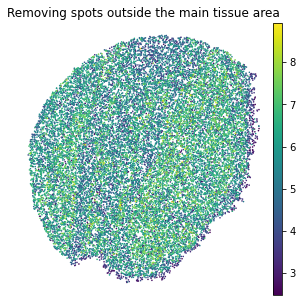

In [11]:
plt.rcParams["figure.figsize"] = (5,5)
sc.pl.embedding(adata, basis="spatial", color="log1p_total_counts",s=10, show=False, title='Removing spots outside the main tissue area')

plt.axis('off')

In [12]:
sc.pp.filter_genes(adata, min_cells=50)
print('After flitering: ', adata.shape)

Trying to set attribute `.var` of view, copying.


After flitering:  (20139, 11750)


In [13]:
#Normalization
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=3000)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

## Constructing the spatial network

------Calculating spatial graph...
The graph contains 228300 edges, 20139 cells.
11.3362 neighbors per cell on average.


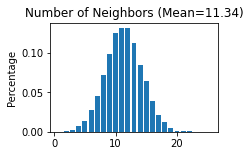

In [14]:
STAGATE_pyG.Cal_Spatial_Net(adata, rad_cutoff=50)
STAGATE_pyG.Stats_Spatial_Net(adata)

## Running STAGATE

In [15]:
adata = STAGATE_pyG.train_STAGATE(adata, device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu'))

Size of Input:  (20139, 3000)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:37<00:00, 26.61it/s]


In [16]:
sc.pp.neighbors(adata, use_rep='STAGATE')
sc.tl.umap(adata)

In [17]:
sc.tl.louvain(adata, resolution=0.5)

In [18]:
adata.obsm["spatial"] = adata.obsm["spatial"] * (-1)

(-5108.555, -588.545, -5670.73, -847.6700000000001)

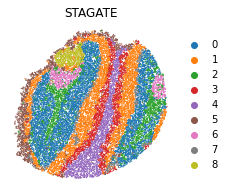

In [19]:
plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.embedding(adata, basis="spatial", color="louvain",s=6, show=False, title='STAGATE')
plt.axis('off')

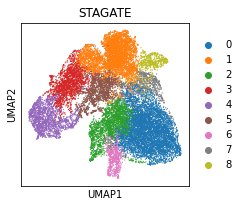

In [20]:
sc.pl.umap(adata, color='louvain', title='STAGATE')